In [1]:
import os
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt


import train
import model
import utils
import gmm


data_dir =  '../data'
model_dir = '../log/demo'

In [2]:
# load dataset and paramters
[train_set, valid_set, test_set, std_train_set, std_valid_set, std_test_set, 
     hps_model, eval_hps_model] = train.load_env(data_dir, model_dir)

Dataset combined: 6763 (train=775/validate=2915/test=3073)
model_params.max_seq_len set to 71.


In [3]:
# construct model:
train.reset_graph()
train_model = model.FontRNN(hps_model)
eval_model = model.FontRNN(eval_hps_model, reuse=True)

INFO:tensorflow:Model using LuongMonotonicAttention.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Model using LuongMonotonicAttention.


In [4]:
# load trained checkpoint
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train.load_checkpoint(sess, model_dir)

Loading model ../log/demo/vector-1900.
INFO:tensorflow:Restoring parameters from ../log/demo/vector-1900


In [5]:
def test_model(sess, testmodel, input_stroke):
    stroke_len = len(input_stroke)
    input_stroke = utils.to_big_strokes(input_stroke, max_len=testmodel.hps.max_seq_len).tolist()
    input_stroke.insert(0, [0, 0, 1, 0, 0])
    feed = {testmodel.enc_input_data: [input_stroke],
            testmodel.enc_seq_lens: [stroke_len],
            }
    output = sess.run([testmodel.pi, testmodel.mu1, testmodel.mu2, testmodel.sigma1,
                       testmodel.sigma2, testmodel.corr, testmodel.pen,
                       testmodel.timemajor_alignment_history],
                      feed)
    gmm_params = output[:-1]
    timemajor_alignment_history = output[7]

    return gmm_params, timemajor_alignment_history


def sample_from_params(params, temp=0.1, greedy=False):
    [o_pi, o_mu1, o_mu2, o_sigma1, o_sigma2, o_corr, o_pen] = params

    max_len = o_pi.shape[0]
    num_mixture = o_pi.shape[1]

    strokes = np.zeros((max_len, 5), dtype=np.float32)

    for step in range(max_len):
        next_x1 = 0
        next_x2 = 0
        eos = [0, 0, 0]
        eos[np.argmax(o_pen[step])] = 1
        for mixture in range(num_mixture):
            x1, x2 = gmm.sample_gaussian_2d(o_mu1[step][mixture], o_mu2[step][mixture],
                                            o_sigma1[step][mixture], o_sigma2[step][mixture],
                                            o_corr[step][mixture], np.sqrt(temp), greedy)
            next_x1 += x1 * o_pi[step][mixture]
            next_x2 += x2 * o_pi[step][mixture]
        strokes[step, :] = [next_x1, next_x2, eos[0], eos[1], eos[2]]
    strokes = utils.to_normal_strokes(strokes)
    return strokes

def draw(delta_gt_stroke, delta_stroke):
    ground_truth_stroke = delta_gt_stroke.copy()
    stroke = delta_stroke.copy()
    
    # convert to absolute coordinate
    scale_factor = 300
    low_tri_matrix = np.tril(np.ones((delta_gt_stroke.shape[0], delta_gt_stroke.shape[0])), 0)
    ground_truth_stroke[:, :2] = np.rint(scale_factor * np.matmul(low_tri_matrix, delta_gt_stroke[:, :2]))
    low_tri_matrix = np.tril(np.ones((delta_stroke.shape[0], delta_stroke.shape[0])), 0)
    stroke[:, :2] = np.rint(scale_factor * np.matmul(low_tri_matrix, delta_stroke[:, :2]))

    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    # plt.xlim(0, 300)
    # plt.ylim(0, 300)
    pre_i = 0
    for i in range(ground_truth_stroke.shape[0]):
        if ground_truth_stroke[i][2] == 1:
            plt.plot(ground_truth_stroke[pre_i:i + 1, 0], ground_truth_stroke[pre_i:i + 1, 1], color='black', linewidth=3)
            pre_i = i + 1
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title("Groud Truth")

    plt.subplot(122)
    # plt.xlim(0, 300)
    # plt.ylim(0, 300)
    pre_i = 0
    for i in range(stroke.shape[0]):
        if stroke[i][2] == 1:
            plt.plot(stroke[pre_i:i + 1, 0], stroke[pre_i:i + 1, 1], color='black', linewidth=3)
            pre_i = i + 1
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.title("Generated")

    plt.show()

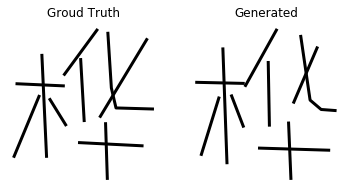

In [6]:
index = random.randint(0, len(std_test_set.strokes)-1)
ref_strokes = np.copy(std_test_set.strokes[index])
real_strokes = np.copy(test_set.strokes[index])

params, timemajor_alignment_history = test_model(sess, eval_model, ref_strokes)
fake_strokes = sample_from_params(params, greedy=True)

draw(real_strokes, fake_strokes)
plt.show()